# Lane Finder (part 1)

This is by far the most complex step for me, which is how to identify the left lane (or the right lane so to speak) and to keep tracking it as it is moving right and left.

I suppose that once I am able to do this with a reasonable level of robustness with regard to outliers, then the rest should not be that difficult.

By analyzing the GB videos of the project video, the challenge video, and the even harder video, I reached a conclusion that I may use the HUE thresholded channel from `get_binary_color` to identify the left lane so to speak. I wish you do not consider this as cheating since in real life scenarios, the left lane need not be yellow and hence good to spot in this fashion.

However, going by the belief that this is acceptable I start by designing my left-lane tracking code using ideas from the class about incremental correction. My plans is as follows:
- Create two mechanisms for spotting the left lane:
    - Inital finding of the lane
    - Incremental finding of the lane
- Design a mask that is robust enough to initially find the lane either in the beginning of the video or after a series of garbage frames or frames with no much useful optical information (i.e. lot of noise due to lighting and others)
- Design a good procedure for incrementally finding the left lane which allows high level of noise rejection in consecutive frames of acceptable optical integrity

## Robust Mask

### Storing Screenshots from all Videos

The first step in building a robust mask is to go over shots from all the three videos. The code snippets below do just that by saving a frame every second to a jpeg file on the same folder. Note that I am saving the GB versions rather than the BW versions as they contain more information from a computer vision poit of view.

In [1]:
import cv2

video_capture = cv2.VideoCapture('project_video_binaryGB_undistorted.mp4')
if True != video_capture.isOpened():
    raise Exception('Please make sure that this notebook is in the same directory as the test videos')
    
fps = int(video_capture.get(cv2.CAP_PROP_FPS))
success = True
counter = 1
while success:
    for n in range(fps):
        success, img = video_capture.read()
        if not success:
            break
    
    if not success:
        break
    cv2.imwrite('test_binary_frame{}.jpg'.format(counter), img)
    counter += 1
    
print("{} frames saved into the disk for using as test images".format(counter))

51 frames saved into the disk for using as test images


In [2]:
video_capture = cv2.VideoCapture('challenge_video_binaryGB_undistorted.mp4')
if True != video_capture.isOpened():
    raise Exception('Please make sure that this notebook is in the same directory as the test videos')
    
fps = int(video_capture.get(cv2.CAP_PROP_FPS))
success = True
counter = 1
while success:
    for n in range(fps):
        success, img = video_capture.read()
        if not success:
            break
    
    if not success:
        break
    cv2.imwrite('challenge_binary_frame{}.jpg'.format(counter), img)
    counter += 1
    
print("{} frames saved into the disk for using as test images".format(counter))

17 frames saved into the disk for using as test images


In [3]:
video_capture = cv2.VideoCapture('harder_video_binaryGB_undistorted.mp4')
if True != video_capture.isOpened():
    raise Exception('Please make sure that this notebook is in the same directory as the test videos')
    
fps = int(video_capture.get(cv2.CAP_PROP_FPS))
success = True
counter = 1
while success:
    for n in range(fps):
        success, img = video_capture.read()
        if not success:
            break
    
    if not success:
        break
    cv2.imwrite('harder_binary_frame{}.jpg'.format(counter), img)
    counter += 1
    
print("{} frames saved into the disk for using as test images".format(counter))

48 frames saved into the disk for using as test images


### Plotting Hue Channel from All Screenshots in One Image

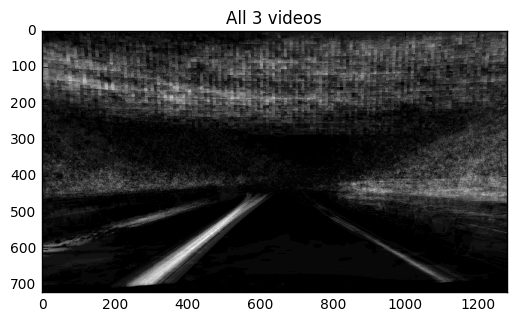

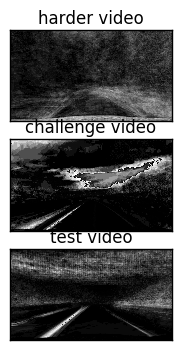

In [2]:
import cv2
import glob
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

filenames = glob.glob("*_binary_frame*.jpg")
img_all = np.zeros((720, 1280), np.uint64)

img_sequence = {}
count_sequence = {}

for filename in filenames:
    img = cv2.imread(filename)

    if img.shape[:2] != img_all.shape[:2]:
        raise Exception('Incompatible test frames encountered')

    sequence = re.search(r'^[^_]+', filename).group(0)
    
    # Add the green channel to the overall accumulator image
    img_all += img[:,:,1]
    
    # Construct other accumulator images for each video separately
    if sequence not in img_sequence.keys():
        img_sequence[sequence] = img_all = np.zeros((720, 1280), np.uint64)
        count_sequence[sequence] = 0
        
    # Add the green channel to the accumulator channel as before
    img_sequence[sequence] += img[:,:,1]
    # Increment the counter for that sequence
    count_sequence[sequence] += 1
    
img_all = (img_all / len(filenames)).astype(np.uint8)
plt.imshow(img_all, cmap="gray")
plt.title("All 3 videos")
plt.show()

mpimg.imsave("accumulator_all.jpg".format(sequence), img_all, cmap="gray")

for index, sequence in enumerate(img_sequence):
    img_accumulator = (img_sequence[sequence] / count_sequence[sequence]).astype(np.uint8)
    plt.subplot(len(img_sequence), 1, index + 1)
    plt.imshow(img_accumulator, cmap="gray")
    plt.title("{} video".format(sequence))
    plt.xticks([])
    plt.yticks([])
    
    mpimg.imsave("accumulator_{}.jpg".format(sequence), img_accumulator, cmap="gray")
    
plt.show()

### Baseline

I was inspired by the sliding window algorithm as I thought it was such a simple and an easy way to achieve something that appears difficult to do. Following the footsteps of the algorithm I am thinking of defining a search baseline which is a horizontal line from which I can move up (i.e. slide) while shifting to track the angle or the curve of the left lane.

In order to do this, I would like to make sure that my baseline is robust enough to help do initial finding of the lane as well as refinding the lane after a couple of bad/noisy frames.

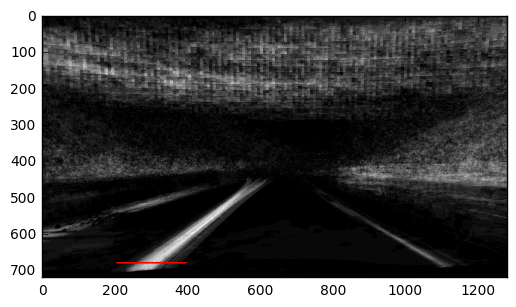

In [5]:
img_accumulator = mpimg.imread('accumulator_all.jpg')
cv2.line(img_accumulator, (205, 680), (395, 680), (255, 0, 0), 4)

plt.imshow(img_accumulator)
plt.show()

Okay so let's try to plot that baseline in some of the videos to get a better intuition of whether this is getting us in the right direction or not.

In [1]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
def process_image(img):
    cv2.line(img, (205, 680), (395, 680), (255, 0, 0), 4)
    return img
    
# The video processing and storing code
input_video = VideoFileClip("project_video_binaryGB_undistorted.mp4")
output_video = input_video.fl_image(process_image)

%time output_video.write_videofile('project_video_binaryGB_undistorted_leftlanebaseline.mp4', audio=False)

[MoviePy] >>>> Building video project_video_binaryGB_undistorted_leftlanebaseline.mp4
[MoviePy] Writing video project_video_binaryGB_undistorted_leftlanebaseline.mp4


100%|█████████████████████████████████████▉| 1260/1261 [01:18<00:00, 14.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_binaryGB_undistorted_leftlanebaseline.mp4 

Wall time: 1min 21s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="project_video_binaryGB_undistorted_leftlanebaseline.mp4">
</video>
""")

In [12]:
# The video processing and storing code
input_video = VideoFileClip("challenge_video_binaryGB_undistorted.mp4")
output_video = input_video.fl_image(process_image)

%time output_video.write_videofile('challenge_video_binaryGB_undistorted_leftlanebaseline.mp4', audio=False)

[MoviePy] >>>> Building video challenge_video_binaryGB_undistorted_leftlanebaseline.mp4
[MoviePy] Writing video challenge_video_binaryGB_undistorted_leftlanebaseline.mp4


100%|████████████████████████████████████████| 485/485 [00:26<00:00, 21.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_binaryGB_undistorted_leftlanebaseline.mp4 

Wall time: 28.6 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="challenge_video_binaryGB_undistorted_leftlanebaseline.mp4">
</video>
""")

In [13]:
# The video processing and storing code
input_video = VideoFileClip("harder_video_binaryGB_undistorted.mp4")
output_video = input_video.fl_image(process_image)

%time output_video.write_videofile('harder_video_binaryGB_undistorted_leftlanebaseline.mp4', audio=False)

[MoviePy] >>>> Building video harder_video_binaryGB_undistorted_leftlanebaseline.mp4
[MoviePy] Writing video harder_video_binaryGB_undistorted_leftlanebaseline.mp4


100%|█████████████████████████████████████▉| 1199/1200 [01:20<00:00, 13.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_video_binaryGB_undistorted_leftlanebaseline.mp4 

Wall time: 1min 23s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="harder_video_binaryGB_undistorted_leftlanebaseline.mp4">
</video>
""")

### Lane-Following Baseline

In this section I will attempt a simple, yet a powerful idea. This is the idea of using a histogram similar to the one described in the lessons to steer the baseline to follow the lane.

I do this by checking continuous ranges (called pulses in the code) while ignoring pulses wider than 50 pixels or narrower than 10 pixels. I also ignore the ones at the beginning or the end of the baseline.

Since sometimes more than one pulse will appear along the red baseline, I will find the mean of these and relocate the baseline there.

In [1]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import itertools
import numpy as np
import cv2

# pulses once applied to an array of binary pixels can be used to discern
# peaks between 10 and 50 pixels wide, returning the translation needed to
# move the center of borderline to the center of each one of the detected
# peaks.
# ADDED FEATURE: during shadows I noticed that an inverse peak occur where
# the lane was supposed to be, I accounted for this with 'active_value'.
def pulses(binary_pixels):
    if binary_pixels.ndim > 1:
        raise Exception('peaks() only work with one-dimensional arrays')
        
    active_value = True
    if binary_pixels[0] and binary_pixels[-1]:
        active_value = False
        
    index = 0
    for value, group in itertools.groupby(binary_pixels):
        length = len(list(group))
        if active_value == bool(value) and length > 10 and length < 50:
            yield int((index + length / 2) - (len(binary_pixels) / 2))
        index += length

# baseline x, y and width
bx = 205
by = 680
bw = 190
def process_image(img):
    global bx, by, bw
    
    baseline_green = img[by, bx:bx+bw, 1]
    baseline_green[baseline_green < 128] = 0
    baseline_green[baseline_green > 127] = 255
    
    bx_newcenter = np.mean(list(pulses(baseline_green)))
    if not np.isnan(bx_newcenter):
        bx += int(bx_newcenter)
    
    cv2.line(img, (bx, by), (bx+bw, by), (255, 0, 0), 4)
    return img

In [10]:
# The video processing and storing code
input_video = VideoFileClip("project_video_binaryGB_undistorted.mp4")
output_video = input_video.fl_image(process_image)

%time output_video.write_videofile('project_video_binaryGB_undistorted_leftlanefollowingbaseline.mp4', audio=False)

[MoviePy] >>>> Building video project_video_binaryGB_undistorted_leftlanefollowingbaseline.mp4
[MoviePy] Writing video project_video_binaryGB_undistorted_leftlanefollowingbaseline.mp4


100%|█████████████████████████████████████▉| 1260/1261 [01:14<00:00, 16.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_binaryGB_undistorted_leftlanefollowingbaseline.mp4 

Wall time: 1min 16s


In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="project_video_binaryGB_undistorted_leftlanefollowingbaseline.mp4">
</video>
""")

In [11]:
# The video processing and storing code
input_video = VideoFileClip("challenge_video_binaryGB_undistorted.mp4")
output_video = input_video.fl_image(process_image)

%time output_video.write_videofile('challenge_video_binaryGB_undistorted_leftlanefollowingbaseline.mp4', audio=False)

[MoviePy] >>>> Building video challene_video_binaryGB_undistorted_leftlanefollowingbaseline.mp4
[MoviePy] Writing video challene_video_binaryGB_undistorted_leftlanefollowingbaseline.mp4


100%|████████████████████████████████████████| 485/485 [00:24<00:00, 21.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challene_video_binaryGB_undistorted_leftlanefollowingbaseline.mp4 

Wall time: 26.6 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="challenge_video_binaryGB_undistorted_leftlanefollowingbaseline.mp4">
</video>
""")

In [19]:
# The video processing and storing code
input_video = VideoFileClip("harder_video_binaryGB_undistorted.mp4")
output_video = input_video.fl_image(process_image)

%time output_video.write_videofile('harder_video_binaryGB_undistorted_leftlanefollowingbaseline.mp4', audio=False)

[MoviePy] >>>> Building video harder_video_binaryGB_undistorted_leftlanefollowingbaseline.mp4
[MoviePy] Writing video harder_video_binaryGB_undistorted_leftlanefollowingbaseline.mp4


100%|█████████████████████████████████████▉| 1199/1200 [01:17<00:00, 12.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_video_binaryGB_undistorted_leftlanefollowingbaseline.mp4 

Wall time: 1min 20s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="harder_video_binaryGB_undistorted_leftlanefollowingbaseline.mp4">
</video>
""")

### Few Enhancements

Did you see what happenned at the end of the harder video? WOW! That was intense!! I have to say that last video was brutal!!!

In order to enhance performance in the last video I thought why not try to incorporate few enhancements:
- Shift the baseline slowly towards its initial position in the lack of any optical leads
- Use optical leads in inverted way when there is shadows and the binary information is inverted (black is lane not white is lane), seen in challenge video and harder video
- Use both of the green and the blue channels but using different restrictions on minimum and maximum pulse widths
- Use a wider baseline and automatically shrink the width due to stable detections of lane. Once the lane detection goes slow grow the baseline's width exponentially fast to original width.
- Use median instead of mean for selecting the peak to follow from the histogram
- Use frame comparison to detect garbage frames on both the green and the blue channels or to assess reliability

In [93]:
# I modified pulses to allow choosing the minimum and the maximum
# pulse widths to help attune the function to the requirements of
# the blue and the green channels
def pulses(binary_pixels, min_width = 10, max_width = 75):
    if binary_pixels.ndim > 1:
        raise Exception('peaks() only work with one-dimensional arrays')
        
    active_value = True
    if np.count_nonzero(binary_pixels) > int(0.7 * binary_pixels.size):
        active_value = False
        
    index = 0
    for value, group in itertools.groupby(binary_pixels):
        length = len(list(group))
        if active_value == bool(value) and \
            length >= min_width and length <= max_width:
            yield int((index + length / 2) - (len(binary_pixels) / 2))
        index += length
        
# baseline x, y and width, added the original, preferred position
bx_original = 205
bx = 205
by = 670
bw_original = 300
bw = 200
idle_counter = 0
previous_img = None
def process_image(img):
    global bx, by, bw, idle_counter, previous_img
    
    diff_green, diff_blue = (0, 0)
    if previous_img is not None:
        diff = cv2.absdiff(img, previous_img)[by-10:by+10,bx:bx+bw,:]
        diff_blue = np.count_nonzero(diff[:,:,2] > 127) * 3 * 255 // diff.size 
        diff_green = np.count_nonzero(diff[:,:,1] > 127) * 3 * 255 // diff.size
    
    baseline_green = img[by, bx:bx+bw, 1]
    baseline_green[baseline_green < 128] = 0
    baseline_green[baseline_green > 127] = 255
    
    baseline_blue = img[by, bx:bx+bw, 2]
    baseline_blue[baseline_blue < 128] = 0
    baseline_blue[baseline_blue > 127] = 255

    green_peaks = list(pulses(baseline_green))
    blue_peaks  = list(pulses(baseline_blue, 2))
    
    if len(green_peaks) > 0 and diff_green < 45:
        idle_counter = 0
        bx_newcenter = np.median(green_peaks) # np.mean(green_peaks)
    elif len(blue_peaks) > 0 and diff_blue < 25:
        bx_newcenter = np.median(blue_peaks)
    else:
        idle_counter += 1
        bx_newcenter = np.nan
        
    if not np.isnan(bx_newcenter):
        bx += int(bx_newcenter)
        if bx < 0:
            bx = 0
        if bx > img.shape[1]-1 - bw:
            bx = img.shape[1]-1 - bw
    else:
        # A time constant of 0.5s assuming an fps of 25
        bx += int((bx_original - bx) / 12.5)
    
    # shrinking at a time constant of 0.25s assuming an fps of 25
    bw -= int((bw - 200) / 6.25)
    # while growing at the same time due to fluctuations in position
    bw += 1 << (idle_counter >> 1)
    # kept under bw_original
    if bw < 200:
        bw = 200
    if bw > bw_original:
        bw = bw_original
            
    cv2.line(img, (bx, by), (bx+bw, by), (255, 0, 0), 4)
    cv2.putText(img, "BLUE:{}".format(str(blue_peaks)), (10, 120), \
                cv2.FONT_HERSHEY_DUPLEX, 1.0, (255,255,255))
    cv2.putText(img, "GREEN:{}".format(str(green_peaks)), (10, 150), \
                cv2.FONT_HERSHEY_DUPLEX, 1.0, (255,255,255))
    
    cv2.rectangle(img, (0,img.shape[0]-50), (49,img.shape[0]-1), \
                  (0, min(255, 4 * diff_green), 0), cv2.FILLED)
    cv2.rectangle(img, (0,img.shape[0]-100), (49,img.shape[0]-51), \
                  (0, 0, min(255, 4 * diff_blue)), cv2.FILLED)
    cv2.putText(img, "%{}".format(str(diff_green)), (10, img.shape[0]-20), \
                cv2.FONT_HERSHEY_DUPLEX, 1.0, ((255,255,255) if diff_green < 45 else (255,0,0)))
    cv2.putText(img, "%{}".format(str(diff_blue)), (10, img.shape[0]-70), \
                cv2.FONT_HERSHEY_DUPLEX, 1.0, ((255,255,255) if diff_blue < 45 else (255,0,0)))
    previous_img = np.copy(img)
    return img

In [94]:
# The video processing and storing code
input_video = VideoFileClip("harder_video_binaryGB_undistorted.mp4")
output_video = input_video.fl_image(process_image)

%time output_video.write_videofile('harder_video_binaryGB_undistorted_leftlanefollowingbaseline2.mp4', audio=False)

[MoviePy] >>>> Building video harder_video_binaryGB_undistorted_leftlanefollowingbaseline2.mp4
[MoviePy] Writing video harder_video_binaryGB_undistorted_leftlanefollowingbaseline2.mp4


100%|█████████████████████████████████████▉| 1199/1200 [01:41<00:00, 11.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_video_binaryGB_undistorted_leftlanefollowingbaseline2.mp4 

Wall time: 1min 45s


In [96]:
HTML("""
<video width="960" height="540" controls>
  <source src="harder_video_binaryGB_undistorted_leftlanefollowingbaseline2.mp4">
</video>
""")

In [91]:
# The video processing and storing code
input_video = VideoFileClip("challenge_video_binaryGB_undistorted.mp4")
output_video = input_video.fl_image(process_image)

%time output_video.write_videofile('challenge_video_binaryGB_undistorted_leftlanefollowingbaseline2.mp4', audio=False)

[MoviePy] >>>> Building video challenge_video_binaryGB_undistorted_leftlanefollowingbaseline2.mp4
[MoviePy] Writing video challenge_video_binaryGB_undistorted_leftlanefollowingbaseline2.mp4


100%|████████████████████████████████████████| 485/485 [00:25<00:00, 19.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_binaryGB_undistorted_leftlanefollowingbaseline2.mp4 

Wall time: 27.1 s


In [39]:
HTML("""
<video width="960" height="540" controls>
  <source src="challenge_video_binaryGB_undistorted_leftlanefollowingbaseline2.mp4">
</video>
""")

In [95]:
# The video processing and storing code
input_video = VideoFileClip("project_video_binaryGB_undistorted.mp4")
output_video = input_video.fl_image(process_image)

%time output_video.write_videofile('project_video_binaryGB_undistorted_leftlanefollowingbaseline2.mp4', audio=False)

[MoviePy] >>>> Building video project_video_binaryGB_undistorted_leftlanefollowingbaseline2.mp4
[MoviePy] Writing video project_video_binaryGB_undistorted_leftlanefollowingbaseline2.mp4


100%|█████████████████████████████████████▉| 1260/1261 [01:26<00:00, 13.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_binaryGB_undistorted_leftlanefollowingbaseline2.mp4 

Wall time: 1min 28s


In [97]:
HTML("""
<video width="960" height="540" controls>
  <source src="project_video_binaryGB_undistorted_leftlanefollowingbaseline2.mp4">
</video>
""")

In [1]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import itertools
import numpy as np
import cv2

def binary_array_cleanup(array):
    if type(array) != np.ndarray:
        raise TypeError
        
    select_high = array > (array.dtype.type(~0) >> 1)
    select_low = ~select_high
    
    array[select_high] = array.dtype.type(~0)
    array[select_low] = array.dtype.type(0)
    
    return array

def binary_array_peaks(vector, min_width = 10, max_width = 75):
        if type(vector) != np.ndarray:
            raise TypeError()
        elif vector.ndim > 1:
            raise ValueError()
        
        vector = binary_array_cleanup(vector)
        
        if np.count_nonzero(vector) > 0.75 * vector.size:
            active_value = False
        else:
            active_value = True
        
        index = 0
        for value, group in itertools.groupby(vector):
            length = len(list(group))
            if active_value == bool(value) and length >= min_width and length <= max_width:
                yield int((index + length / 2) - (vector.size / 2))
                
            index += length
  
class lane_baseline:
    def __init__(self, x, y, min_width, max_width):
        if type(x) != int or type(y) != int or type(min_width) != int or type(max_width) != int:
            raise TypeError()
        
        self.x = x
        self.x0 = x
        self.y = y
        self.w = min_width
        self.w_min = min_width
        self.w_max = max_width
        self.idle_counter = 0
        self.previous_img = None
        self.blue_reliability = 1.0
        self.green_reliability = 1.0
    
    def __call__(self, img):
        if self.previous_img is not None:
            diff = binary_array_cleanup(cv2.absdiff(img, self.previous_img) \
                [self.y-10:self.y+10, max(0,self.x-50):min(img.shape[1],self.x+self.w),:])
    
            self.green_reliability *= 1.0 - np.count_nonzero(diff[:,:,1]) / diff[:,:,1].size
            self.blue_reliability *= 1.0 - np.count_nonzero(diff[:,:,2]) / diff[:,:,2].size
        
        # A time constant of 0.25s assuming an fps of 25
        self.green_reliability += (1.0 - self.green_reliability) / 6.25
        self.blue_reliability += (1.0 - self.blue_reliability) / 6.25
                 
        baseline_green = img[self.y, self.x:self.x+self.w, 1]
        baseline_blue = img[self.y, self.x:self.x+self.w, 2]

        green_peaks = list(binary_array_peaks(baseline_green))
        blue_peaks  = list(binary_array_peaks(baseline_blue, 2))
    
        if len(green_peaks) > 0 and self.green_reliability > 0.75:
            self.idle_counter = 0
            x_newcenter = np.median(green_peaks) 
        elif len(blue_peaks) > 0 and self.blue_reliability > 0.85:
            self.idle_counter = 0
            x_newcenter = np.median(blue_peaks)
        else:
            self.idle_counter += 1
            x_newcenter = np.nan
        
        if not np.isnan(x_newcenter):
            self.x += int(x_newcenter)
            self.x = max(0, self.x)
            self.x = min(img.shape[1] - 1 - self.w, self.x)
        else:
            # A time constant of 0.5s assuming an fps of 25
            self.x += int((self.x0 - self.x) / 12.5)

        # shrinking at a time constant of 0.25s assuming an fps of 25
        self.w -= int((self.w - self.w_min) / 6.25)
        # while growing at the same time due to fluctuations in position
        self.w += 1 << (self.idle_counter >> 1)
        # kept under bw_original
        self.w = max(self.w_min, self.w)
        self.w = min(self.w_max, self.w)

        self.previous_img = np.copy(img)
        return int(self.x), int(self.y), int(self.w)

rightlane_baseline = lane_baseline(920, 670, 190, 300)
leftlane_baseline = lane_baseline(205, 670, 190, 300)
def process_image(img):
    x, y, w = leftlane_baseline(img)
    cv2.line(img, (x, y), (x + w, y), (255, 0, 0), 4)
    x, y, w = rightlane_baseline(img)
    cv2.line(img, (x, y), (x + w, y), (255, 255, 0), 4)
    
    return img

In [2]:
# The video processing and storing code
input_video = VideoFileClip("challenge_video_binaryGB_undistorted.mp4")
output_video = input_video.fl_image(process_image)

%time output_video.write_videofile('challenge_video_binaryGB_undistorted_leftlanefollowingbaseline3.mp4', audio=False)

[MoviePy] >>>> Building video challenge_video_binaryGB_undistorted_leftlanefollowingbaseline3.mp4
[MoviePy] Writing video challenge_video_binaryGB_undistorted_leftlanefollowingbaseline3.mp4


100%|████████████████████████████████████████| 485/485 [00:25<00:00, 19.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_binaryGB_undistorted_leftlanefollowingbaseline3.mp4 

Wall time: 26.8 s


In [53]:
HTML("""
<video width="960" height="540" controls>
  <source src="challenge_video_binaryGB_undistorted_leftlanefollowingbaseline2.mp4">
</video>
""")

In [3]:
# The video processing and storing code
input_video = VideoFileClip("harder_video_binaryGB_undistorted.mp4")
output_video = input_video.fl_image(process_image)

%time output_video.write_videofile('harder_video_binaryGB_undistorted_leftlanefollowingbaseline3.mp4', audio=False)

[MoviePy] >>>> Building video harder_video_binaryGB_undistorted_leftlanefollowingbaseline3.mp4
[MoviePy] Writing video harder_video_binaryGB_undistorted_leftlanefollowingbaseline3.mp4


100%|█████████████████████████████████████▉| 1199/1200 [01:23<00:00, 10.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_video_binaryGB_undistorted_leftlanefollowingbaseline3.mp4 

Wall time: 1min 27s


In [6]:
HTML("""
<video width="960" height="540" controls>
  <source src="harder_video_binaryGB_undistorted_leftlanefollowingbaseline3.mp4">
</video>
""")

In [5]:
# The video processing and storing code
input_video = VideoFileClip("project_video_binaryGB_undistorted.mp4")
output_video = input_video.fl_image(process_image)

%time output_video.write_videofile('project_video_binaryGB_undistorted_leftlanefollowingbaseline3.mp4', audio=False)

[MoviePy] >>>> Building video project_video_binaryGB_undistorted_leftlanefollowingbaseline3.mp4
[MoviePy] Writing video project_video_binaryGB_undistorted_leftlanefollowingbaseline3.mp4


100%|█████████████████████████████████████▉| 1260/1261 [01:32<00:00, 13.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_binaryGB_undistorted_leftlanefollowingbaseline3.mp4 

Wall time: 1min 34s


In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="project_video_binaryGB_undistorted_leftlanefollowingbaseline2.mp4">
</video>
""")

### One Last Enhancement

As I am working my throughout this development, I am getting more ideas. The idea that I have in the moment has to do with one of the lanes (right or left) giving feedback to the other lane, seems like an idea of potential.

To this programmatically, I am thinking of creating an upper entity whose function is to take the "rationale" of each lane baseline object and use the information from teo or more lane baseline entities to actually make the final decision on where each lane is supposed to be.

The general thinking at this stage is that we are able not only to get lane position information from each lane baseline object, but also a level of confidence through our concept of using `np.absdiff`. Having said that we might have the following scenarios:
- Both right and left lanes are detected from reliable optical leads, in this case derive an assumedly constant piece of information (i.e. 'lane width'), and update it in a moving average way requiring as many confident readings as a solid dash line in the right lane to stabilize it.
- One of the right or left lane reading is less confident, in this case use the measured 'lane width' to locate the less confident lane line.

Note that I am thinking that (especially in the last brutal video) this might, rightfully, push one of the lanes outside of the image frame which makes me believe that we should be able to code that scenario as well.

In [2]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import itertools
import numbers
import numpy as np
import cv2

def binary_array_cleanup(array):
    if type(array) != np.ndarray:
        raise TypeError
        
    select_high = array > (array.dtype.type(~0) >> 1)
    select_low = ~select_high
    
    array[select_high] = array.dtype.type(~0)
    array[select_low] = array.dtype.type(0)
    
    return array

def binary_array_peaks(vector, min_width = 10, max_width = 75):
        if type(vector) != np.ndarray:
            raise TypeError()
        elif vector.ndim > 1:
            raise ValueError()
        
        vector = binary_array_cleanup(vector)
        
        if np.count_nonzero(vector) > 0.75 * vector.size:
            active_value = False
        else:
            active_value = True
        
        index = 0
        for value, group in itertools.groupby(vector):
            length = len(list(group))
            if active_value == bool(value) and length >= min_width and length <= max_width:
                yield int((index + length / 2) - (vector.size / 2))
                
            index += length

class lane_negotiator:
    def __init__(self, leftlane, rightlane):
        if not isinstance(leftlane, lane_baseline) or not isinstance(rightlane, lane_baseline):
            raise TypeError()
        self.leftlane  = leftlane
        self.rightlane = rightlane
        self.lanewidth = 720
        self.lanewidth_reliability = 0.5
        self.lanewidth_reliability1 = 0.0 # P
        self.lanewidth_reliability2 = 1.0 # I
    def __call__(self, img):
        clarification_text = ""
        if bool(self.leftlane) and bool(self.rightlane):
            rightlane_center, na = self.rightlane.newx(img)
            rightlane_center += self.rightlane.neww(img)//2
            leftlane_center, na = self.leftlane.newx(img)
            leftlane_center += self.leftlane.neww(img)//2
            measurement = abs(rightlane_center - leftlane_center)
            self.lanewidth += int((measurement - self.lanewidth) / 12.5)
            self.lanewidth_reliability1 = 1.0 - (abs(self.lanewidth - measurement) / self.lanewidth)
            self.lanewidth_reliability2 *= 1.25 - (abs(self.lanewidth - measurement) / self.lanewidth)
            self.lanewidth_reliability2 = min(self.lanewidth_reliability2, 1)
            self.lanewidth_reliability = self.lanewidth_reliability1
            clarification_text += "| measurement taken ({}) ".format(measurement)
        else:
            self.lanewidth_reliability -= (0.15 / 25 / self.lanewidth_reliability2)
            clarification_text += "| measurement reliability decaying"
            
        if self.lanewidth_reliability > 0.75:
            if self.rightlane < self.leftlane:
                self.rightlane.set_center(self.leftlane.get_center() + self.lanewidth)
                clarification_text += "| right line pushed to distance"
            if self.leftlane < self.rightlane:
                self.leftlane.set_center(self.rightlane.get_center() - self.lanewidth)
                clarification_text += "| left line pushed to distance"
                    
        x1, y1, w1, text1 = self.leftlane(img)
        cv2.line(img, (x1, y1), (x1 + w1, y1), (255, 0, 0), 4)
        x2, y2, w2, text2 = self.rightlane(img)
        cv2.line(img, (x2, y2), (x2 + w2, y2), (255, 255, 0), 4)
        
        clarification_text += "| left:{}, right:{} ".format(text1, text2)
        
        if self.lanewidth_reliability > 0.75:
            x1c = self.leftlane.get_center()
            x2c = self.rightlane.get_center()
            cv2.line(img, (x1c, y1+10), (x2c, y2+10), (255, 255, 255), 1)
            cv2.line(img, (x1c, y1-5+10), (x1c, y1+5+10), (255, 255, 255), 1)
            cv2.line(img, (x2c, y2-5+10), (x2c, y2+5+10), (255, 255, 255), 1)
            cv2.putText(img, str(self.lanewidth), \
                    ((x1c+x2c)//2,(y1+y2)//2+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255))
            
        cv2.putText(img, "measured lane width persistence: {} s".format(int(self.lanewidth_reliability2)), \
                    (10,50), cv2.FONT_HERSHEY_DUPLEX, 1.0, (255,255,255))
        cv2.putText(img, "measured lane width: {} (%{} confident)".format(self.lanewidth, int(100*self.lanewidth_reliability)), \
                    (10,100), cv2.FONT_HERSHEY_DUPLEX, 1.0, (255,255,255))
        cv2.putText(img, "current lane width: {}".format(x2+(w2//2) - (x1+(w1//2))), \
                    (10,150), cv2.FONT_HERSHEY_DUPLEX, 1.0, (255,255,255))
        cv2.putText(img, "GREEN PEAKS: left{}%{} right{}%{}".format( \
                    self.leftlane.green_peaks, int(self.leftlane.green_reliability*100), \
                    self.rightlane.green_peaks, int(self.rightlane.green_reliability*100)), \
                    (10,200), cv2.FONT_HERSHEY_DUPLEX, 1.0, (255,255,255))
        cv2.putText(img, "BLUE PEAKS: left{}%{} right{}%{}".format( \
                    self.leftlane.blue_peaks, int(self.leftlane.blue_reliability*100), \
                    self.rightlane.blue_peaks, int(self.rightlane.blue_reliability*100)), \
                    (10,250), cv2.FONT_HERSHEY_DUPLEX, 1.0, (255,255,255))
        if self.leftlane.outside_frame or self.rightlane.outside_frame:
            cv2.putText(img, "LANE LINE WENT OUTSIDE FRAME", \
                    (10,250), cv2.FONT_HERSHEY_DUPLEX, 1.0, \
                    (int(self.leftlane.outside_frame)*255,int(self.rightlane.outside_frame)*255), 0)
        cv2.putText(img, "idle_count: left:{}, right:{}".format(self.leftlane.idle_counter, self.rightlane.idle_counter), \
                (10,300), cv2.FONT_HERSHEY_DUPLEX, 1.0, (255,255,255), 0)
        cv2.putText(img, clarification_text, \
                (10,350), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255,255,255), 1)
        cv2.putText(img, "valid left reading: {}, valid right reading: {}".format( \
                bool(self.leftlane), bool(self.rightlane)), \
                (10,400), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255,255,255), 1)
        return img
        
class lane_baseline:
    def __init__(self, x, y, min_width, max_width):
        if type(x) != int or type(y) != int or type(min_width) != int or type(max_width) != int:
            raise TypeError()
        
        self.x = x
        self.x0 = x
        self.y = y
        self.w = min_width
        self.w_min = min_width
        self.w_max = max_width
        self.idle_counter = 0
        self.previous_img = None
        self.blue_reliability = 1.0
        self.green_reliability = 1.0
        self.blue_peaks = []
        self.green_peaks = []
        self.decision_index = 0
        self.external_setting = False
        self.outside_frame = False
    def __bool__(self):
        return (len(self.green_peaks) > 0 and self.green_reliability > 0.75) or \
            (len(self.blue_peaks) > 0 and self.blue_reliability > 0.80)
    def __lt__(self, other):
        if self.decision_index < other.decision_index:
            return True
        if self.decision_index == other.decision_index:
            if 2 == self.decision_index:
                return self.green_reliability < self.green_reliability
            elif 1 == self.decision_index:
                return self.blue_reliability < self.blue_reliability
    def get_center(self):
        return int(self.x + (self.w/2))
    def set_center(self, x_center):
        self.x_center = int(x_center)
        self.external_setting = True
    def neww(self, img):
        neww = self.w
        # shrinking at a time constant of 0.25s assuming an fps of 25
        neww -= int((self.w - self.w_min) / 6.25)
        # while growing at the same time due to fluctuations in position
        neww += 1 << (self.idle_counter >> 1)
        # kept under bw_original
        neww = max(self.w_min, neww)
        neww = min(self.w_max, neww)
        return neww
    def newreliability(self, img):
        gr, br = self.green_reliability, self.blue_reliability
        w = self.neww(self)
        if self.previous_img is not None:
            diff = binary_array_cleanup(cv2.absdiff(img, self.previous_img) \
                [self.y-10:self.y+10, max(0,self.x-50):min(img.shape[1],self.x+w),:])
            if diff.size > 0:
                gr *= 1.0 - (np.count_nonzero(diff[:,:,1]) / diff[:,:,1].size)
                br *= 1.0 - (np.count_nonzero(diff[:,:,2]) / diff[:,:,2].size)
        # A time constant of 0.25s assuming an fps of 25      
        gr += (1.0 - gr) / 6.25
        br += (1.0 - br) / 6.25
        return gr, br
    def newx(self, img):
        w = self.neww(self)
        baseline_green = img[self.y, max(0,self.x):min(img.shape[1],self.x+w), 1]
        baseline_blue = img[self.y, max(0,self.x):min(img.shape[1],self.x+w), 2]

        gr, br = self.newreliability(img)
        gp, bp = None, None
        
        if len(baseline_green) > 0 and len(baseline_blue) > 0:
            gp = list(binary_array_peaks(baseline_green))
            bp  = list(binary_array_peaks(baseline_blue, 2))

            if not self.external_setting:
                if len(gp) > 0 and gr > 0.75:
                    x = self.x + int(np.median(gp))
                elif len(bp) > 0 and br > 0.80:
                    x = self.x + int(np.median(bp))
                else:
                    x = self.x + int((self.x0 - self.x) / 12.5)
            else:
                x = self.x_center - (w//2)
            
        return x, (baseline_green, baseline_blue, gp, bp)
    def __call__(self, img, change_state=True):
        text = ""  
        #COMPUTE STATE
        w = self.neww(img)
        gr, br = self.newreliability(img)
        x, (baseline_green, baseline_blue, gp, bp) = self.newx(img)
        text = ""
        # CHANGE STATE
        if (change_state): # no text will be provided
            self.previous_img = np.copy(img)
            self.w = w
            self.green_reliability = gr
            self.blue_reliability = br
            self.x = x

            if len(baseline_green) > 0 and len(baseline_blue) > 0:
                self.outside_frame = False
                self.green_peaks = gp
                self.blue_peaks  = bp

                if not self.external_setting:
                    if len(gp) > 0 and gr > 0.75:
                        self.idle_counter = 0
                        self.decision_index = 2
                        text += "G"
                    elif len(bp) > 0 and br > 0.80:
                        self.idle_counter = 0
                        self.decision_index = 1
                        text += "B"
                    else:
                        self.idle_counter += 1
                        self.decision_index = 0
                        text += "-"
                else:
                    self.idle_counter = 0
                    self.decision_index = -1
                    self.external_setting = False
                    text += "X"
            else:
                self.idle_counter += 1
                self.decision_index = 0
                self.outside_frame = True
                self.green_peaks = []
                self.blue_peaks = []
            
        return int(x), int(self.y), int(w), text
      

In [71]:
# The video processing and storing code
input_video = VideoFileClip("challenge_video_binaryGB_undistorted.mp4")
output_video = input_video.fl_image(lane_negotiator( \
    lane_baseline(205, 670, 190, 300),
    lane_baseline(920, 670, 190, 300)))

%time output_video.write_videofile('challenge_video_binaryGB_undistorted_lanefollowing.mp4', audio=False)

[MoviePy] >>>> Building video challenge_video_binaryGB_undistorted_lanefollowing.mp4
[MoviePy] Writing video challenge_video_binaryGB_undistorted_lanefollowing.mp4


100%|████████████████████████████████████████| 485/485 [00:29<00:00, 16.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_binaryGB_undistorted_lanefollowing.mp4 

Wall time: 31 s


In [4]:
HTML("""
<video width="960" height="540" controls>
  <source src="challenge_video_binaryGB_undistorted_lanefollowing.mp4">
</video>
""")

In [3]:
# The video processing and storing code
input_video = VideoFileClip("harder_video_binaryGB_undistorted.mp4")
output_video = input_video.fl_image(lane_negotiator( \
    lane_baseline(205, 670, 190, 300),
    lane_baseline(920, 670, 190, 300)))

%time output_video.write_videofile('harder_video_binaryGB_undistorted_lanefollowing.mp4', audio=False)

[MoviePy] >>>> Building video harder_video_binaryGB_undistorted_lanefollowing.mp4
[MoviePy] Writing video harder_video_binaryGB_undistorted_lanefollowing.mp4


100%|█████████████████████████████████████▉| 1199/1200 [01:32<00:00, 12.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_video_binaryGB_undistorted_lanefollowing.mp4 

Wall time: 1min 35s


In [5]:
HTML("""
<video width="960" height="540" controls>
  <source src="harder_video_binaryGB_undistorted_lanefollowing.mp4">
</video>
""")

In [74]:
# The video processing and storing code
input_video = VideoFileClip("project_video_binaryGB_undistorted.mp4")
output_video = input_video.fl_image(lane_negotiator( \
    lane_baseline(205, 670, 190, 300),
    lane_baseline(920, 670, 190, 300)))

%time output_video.write_videofile('project_video_binaryGB_undistorted_lanefollowing.mp4', audio=False)

[MoviePy] >>>> Building video project_video_binaryGB_undistorted_lanefollowing.mp4
[MoviePy] Writing video project_video_binaryGB_undistorted_lanefollowing.mp4


100%|█████████████████████████████████████▉| 1260/1261 [01:39<00:00, 12.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_binaryGB_undistorted_lanefollowing.mp4 

Wall time: 1min 41s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="project_video_binaryGB_undistorted_lanefollowing.mp4">
</video>
""")

## Conclusion

I am not going to deny that the code above is absolutely messy but I am happy to have explored the wide variety of techniques that I did try which is at the core of my learning experience.

Now I am going to move forward to tracing the lane itself, while carrying the two messy classes I created above as the foundation for my later work. Hence I will indeed incorporate the code above into my pipeline.